<a href="https://colab.research.google.com/github/arvindhvasu/SarcasmDetection/blob/main/NLP_Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection


## Install `Tensorflow2.0` 

In [ ]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 116kB/s 
     |████████████████████████████████| 3.8MB 32.7MB/s 
     |████████████████████████████████| 450kB 39.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=143a7012579fa88a47813ee35c8ab887f4381c9792365dd66f39056f720b2af5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


## Get Required Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Set your project path 
project_path =  'drive/My Drive/Colab Notebooks/NLP2'

#**## Reading and Exploring Data**

## Read the data "Sarcasm_Headlines_Dataset.json" using pandas.read_json function. 

In [ ]:
import os
arr = os.listdir(project_path)
print(arr)

['Sarcasm_Headlines_Dataset.json', 'glove6b.zip']


In [ ]:
import pandas as pd 
data = pd.read_json(project_path+'/Sarcasm_Headlines_Dataset.json', lines=True, orient='records') 
data.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
print(data['is_sarcastic'].value_counts())
print(data.count())

0    14985
1    13634
Name: is_sarcastic, dtype: int64
is_sarcastic    28619
headline        28619
article_link    28619
dtype: int64


**Data Exploration:**
The dataset contains three columns 
1) is_sarcastic: 1 if the record is sarcastic else 0 
2) headline: the headline of the news article 
3) article_link: link to the original news article.

Total count of dataset is 28619 records, in which 13634 records are sarcastic headlines and 14985 records have non sarcastic headlines.

Dataset is almost balanced.


## Drop `article_link` from dataset. 
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [ ]:
data = data.drop(['article_link'], axis = 1) 

## Get the Length of each line and find the maximum length.
As different lines are of different length. We need to pad the our sequences using the max length.

In [ ]:
data.headline.str.len().max()

926

In [ ]:
data["headline"]= data["headline"].str.pad(926, side ='right', fillchar ='_') 
data.head(3)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different reci...


In [ ]:
print(data.headline[0])

thirtysomething scientists unveil doomsday clock of hair loss_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


#**## Modelling**

## Import required modules required for modelling.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model.

In [ ]:
max_features = 20000
maxlen = 50
embedding_size = 300

## Apply Keras Tokenizer of headline column of the data using .fit_on_texts().

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['headline']) 

# Define X and y for your model.

In [ ]:
X = tokenizer.texts_to_sequences(data['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 28619
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 16003   354  3166  7473  2643     2
   660  1118]
Number of Labels:  28619
1


## Get the Vocabulary size

In [ ]:
num_words = len(tokenizer.word_index) + 1
print(num_words)


30885


#**## Word Embedding**

## Get Glove Word Embeddings

In [ ]:
glove_file = project_path + "/glove6b.zip"

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file,

In [ ]:
EMBEDDING_FILE = './glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



# Create a weight matrix for words in the training docs

In [ ]:
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [ ]:
print(X.shape)
print(y.shape)

(28619, 50)
(28619,)


## Model Building


In [ ]:
### Embedding layer for hint 
## model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
### Bidirectional LSTM layer for hint 
## model.add(Bidirectional(LSTM(128, return_sequences = True)))
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(32)))
model.add(Flatten())
model.add(Dense(24,activation = 'relu')),
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         9265500   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 128)         186880    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 64)                41216     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 24)                1560      
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

# Fit the model with a batch size of 100 and validation_split = 0.2.

In [ ]:
from sklearn.model_selection import train_test_split

batch_size = 100
epochs = 5

## Add your code here ##
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(22895, 50) (22895,)
(5724, 50) (5724,)


In [ ]:
history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size, verbose = 2, validation_data=(X_test,Y_test))

Train on 22895 samples, validate on 5724 samples
Epoch 1/5
22895/22895 - 133s - loss: 0.4322 - accuracy: 0.7939 - val_loss: 0.3222 - val_accuracy: 0.8566
Epoch 2/5
22895/22895 - 126s - loss: 0.2150 - accuracy: 0.9167 - val_loss: 0.2992 - val_accuracy: 0.8749
Epoch 3/5
22895/22895 - 128s - loss: 0.1090 - accuracy: 0.9609 - val_loss: 0.3819 - val_accuracy: 0.8712
Epoch 4/5
22895/22895 - 126s - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.5251 - val_accuracy: 0.8672
Epoch 5/5
22895/22895 - 126s - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.6430 - val_accuracy: 0.8658


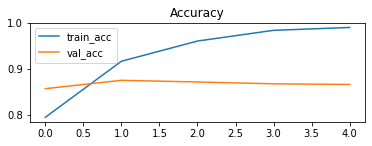

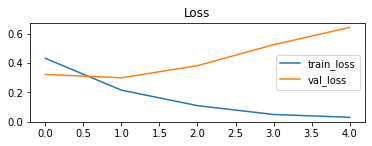

In [ ]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
r_epochs = range(epochs)

plt.subplot(2,1,1)
plt.plot(r_epochs,train_accuracy)
plt.plot(r_epochs,val_accuracy)
plt.legend(['train_acc','val_acc'])
plt.title('Accuracy')
plt.show()

plt.subplot(2,1,2)
plt.plot(r_epochs,train_loss)
plt.plot(r_epochs,val_loss)
plt.legend(['train_loss','val_loss'])
plt.title('Loss')
plt.show()

The Perfomance result of this model is,
On the Training set, the Accuracy is 99% and the loss is 2%
On the Validation set, the Accuracy is 86% and the los is 64%

